In [1]:
LOCAL = True

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")

    data_section = "local_data"
else:
    data_section = "data"
    
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# read and write to config

In [2]:
PLATE1="plate1.xls"

In [3]:

CONFIG = os.path.join(os.path.dirname(os.getcwd()), "config.ini")
config, cfn = crw.read(CONFIG)
CL = "WTC11.1"
DATE= "20240529"
N_PLATES = 2
PLATE_FORMAT =96
NROWS_USED = 7
section = f"{DATE}_PEMF_{CL}"
crw.check(config, section)

# read
DATA_PATH = config[data_section]["data"]
RE = config[data_section]["results"]


# load
QPCR_PATH = os.path.join(DATA_PATH, "experiments", section)
PLATE1="plate1.xls"



COMBINED = "qRT_PEMF.tsv"
LABELS = f"{DATE}_qPCR_labels.xlsx"

# write
config[section]["path"] = QPCR_PATH
config[section]["plate1"] = f"%(path)s/{PLATE1}"
config[section]["labels"] = f"%(path)s/{LABELS}"

if N_PLATES > 1:
    PLATE2="plate2.xls"
    COMBINED = "qRT_PEMF.tsv"
    config[section]["plate2"] = f"%(path)s/{PLATE2}"
    config[section]["plate_combined"] = f"%(path)s/{COMBINED}"

crw.write(config, cfn)

RE_DDCT = os.path.join(RE, f"{DATE}.ddCTs.tsv")

# go to datapath
os.chdir(QPCR_PATH)

# labels

In [4]:
sample=pd.read_excel(LABELS, sheet_name="sample")
sample = sample.rename(columns={"Sample":'sample_id',
                               "Sample_group":"sample_name", 
                               "Replicate_w": "rep", 
                               "Plate":"plate"
                              })
sample

,sample_id,sample_name,rep,Experiment,Cell_line
0,S1,Ctrl 60’,1,1,WTC11_NGN2
1,S2,Ctrl 60’,2,1,WTC11_NGN2
2,S3,Ctrl 60’,3,1,WTC11_NGN2
3,S4,Ctrl 60’,4,1,WTC11_NGN2
4,S5,PEMF 60’,1,1,WTC11_NGN2
5,S6,PEMF 60’,2,1,WTC11_NGN2
6,S7,PEMF 60’,3,1,WTC11_NGN2
7,S8,PEMF 60’,4,1,WTC11_NGN2


## function

In [5]:
def plateToLongform(df, col_name):
    """transpose plate format into longform dataframe, name column"""
    transpose={}
    for n, row in df.iterrows():
        transpose[n] = row
    
    # make dataframe
    dfT = pd.DataFrame(pd.concat(transpose.values())).reset_index()

    # rename columns
    dfT.columns = ["col_pos", col_name]
    return dfT
    

In [6]:
def mergeDataFrames(df1, df2, col=None):
    """left merge two dataframes on index"""
    
    if col != None:
        merged = pd.merge(df1, df2, on=col)
    else:
        merged = pd.merge(df1, df2, left_index=True, right_index=True)
    return merged

In [7]:
def computeCT(df, control_gene):

    # mean ACTB CT per sample
    mean_ctrl = df[df['primers'] == control_gene].groupby('sample_name')['CT'].mean().reset_index()
    
    # rename columns
    mean_ctrl.rename(columns={'CT': 'Control_mean'}, inplace=True)
    
    
    # Merge mean ACTB values per sample
    test = pd.merge(df, mean_ctrl, on='sample_name', how='left')
    
    # dCT = obs CT - ACTB mean CT
    test['dCT'] = test['CT'] - test['Control_mean']
    
    # per experiment, compute ddCT
    results={}  # collect results per experiment
    
    # mean dCT per gene for control sample
    for experiment in set(test['Experiment'].unique()):  # keep the experiment controlled for
        if str(experiment) != "nan":
            print(experiment)
        
            test_ex_ = test.loc[test["Experiment"]== experiment].copy()
            for cl in list(set(test_ex_['Cell_line'])):
                test_ex = test_ex_.loc[test_ex_["Cell_line"]==cl]
            
    
                control_dCTs = test_ex[(test_ex['sample_name'].str.contains('Control'))|
                                        test_ex['sample_name'].str.contains('Ctrl')
                                        ].groupby(['primers'])['dCT'].mean().reset_index()  
                
        
                # rename columns
                control_dCTs.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)
        
                # Merge control sample dCT values per gene
                test_ex = pd.merge(test_ex, control_dCTs, on='primers', how='left')
                
        
                # ddCT = mean(dCT) sample - mean(dCT) control sample
                test_ex['ddCT'] = test_ex['dCT'] - test_ex['Control_dCT_mean']
        
                # Assuming 'test' contains the 'ddCT' values for each gene
        
                # Calculate fold change using the formula 2^(-ddCT)
                test_ex['fold_change'] = 2 ** (-test_ex['ddCT'])
                
                results[f"{experiment}.{cl}"] = test_ex

    return pd.concat(results.values())

In [8]:
def plotDct(df_ex, gene, control_gene, date):


    data_ = df_ex.loc[(df_ex['sample_name'] != "noRT") &
                    (df_ex["primers"] == gene)
                    ].copy().dropna()
    
    
    plot = data_.groupby(["sample_name", "primers",  "rep", ])[
        "fold_change"].mean().reset_index()
    
    # get sample comparisons (ctrl v. pemf60)
    comparisons = list(itertools.combinations(list(set(plot["sample_name"])), 2) )
    
    # stats
    for c in comparisons:
        statP, p = stats.ttest_ind(data_.loc[data_["sample_name"] == c[0], "dCT"].to_list(),
                                     data_.loc[data_["sample_name"] == c[1], "dCT"].to_list())
        print(f"exp1 {c[0]} v. {c[1]} dCT", gene, p)
    
        x = "sample_name"
        y = 'fold_change'
        hue = "rep"
        data = plot
        #    order = ["PEMF 60' exp1", "PEMF 60' exp2"]
        print(x, y)
    
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.boxplot(data=data,
                    x=x, y=y,
                    #order=order,
                    color="grey",
    
                    )
    
        sns.swarmplot(data=data, x=x, y=y,
                      hue=hue,
                      palette="Set2",
                      #order=order,
                      alpha=0.8, size=10)
    
        exp = int(list(set(data_["Experiment"]))[0])
        ax.set(xlabel=f'exp{exp} p={"{:.2E}".format(p)}',
               ylabel='Fold Change (2**-ddCT)',
               title=gene,
               #ylim=(0.2, 4)
    
               )
        ax.axhline(1, ls="--", color="grey", alpha=0.2)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                           horizontalalignment="right")
    
        plt.legend(title='replicate', bbox_to_anchor=(1, 1), frameon=False)
    
        comp_name = "_".join(c).strip(" ") # make comparison name for writing out pdf
        out = os.path.join(RE, f"{date}_hs.{control_gene}.{gene}.{comp_name}.pdf")
        if os.path.exists(out) is False:
            plt.savefig(out, bbox_inches="tight")
    
        # Show the plot
        plt.show()

## primers

In [9]:
# assumes no header names
SHEETS = ["platemap1-primers", "platemap2-primers"][:N_PLATES]
primer_dict={}
for sheet in SHEETS:
    primers=pd.read_excel(LABELS, sheet_name=sheet,
                          header=None
                         )

    # name columns
    primers.columns = np.arange(1, primers.shape[1]+1)

    # transform to longform
    col_name="primers"
    primersT= plateToLongform(primers, col_name)
    
    # edit names
    primersT.loc[primersT["primers"]=="Hsp70c", 'primers'] = "HSP70C"
    primersT.loc[primersT["primers"]=="HSP70c", 'primers'] = "HSP70C"
    primersT["primers"]=primersT["primers"].apply(lambda x: x.strip()) # strip white

    # add to dictionary
    primer_dict[sheet] = primersT

# drop the old index
primersT = pd.concat(primer_dict.values()).reset_index(drop=True)
primersT

,col_pos,primers
0,1,GAPDH
1,2,GAPDH
2,3,GAPDH
3,4,GAPDH
4,5,GAPDH
...,...,...
163,8,CNTN1
164,9,NRXN1
165,10,NRXN1
166,11,EGR1


## cdna

In [10]:
CDNAS = ["platemap1-cdna", "platemap2-cdna"][:N_PLATES]
cdna_dict={}
for sheet in CDNAS:

    cdna = pd.read_excel(LABELS, sheet_name=sheet, 
                         header=None, #names=np.arange(1, NROWS_USED)
                        )
    cdna.columns = np.arange(1, cdna.shape[1]+1)

    col_name = "sample_id"
    cdnaT = plateToLongform(cdna, col_name)
    
    # rename empty columns
    cdnaT.loc[cdnaT['sample_id']=="empty", 'sample_id'] = 'noRT'
    cdnaT.loc[cdnaT['sample_id'].isna(), 'sample_id'] = 'noRT'
    
    # add to dictionary
    cdna_dict[sheet] = cdnaT

cdnaT = pd.concat(cdna_dict.values()).reset_index(drop=True)

## results

In [11]:
cdna.shape

(7, 12)

In [12]:
ROWS = ["A", "B", "C", "D", "E", 'F', "G", "H", "I", "J", "K", 
       "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"][:cdna.shape[0]]

alphanum =[]
for letter in ROWS:
    for n in np.arange(1, cdna.shape[1]+1):
        alphanum.append(f"{letter}{n}")
        
# make df from columns
plate_map = pd.DataFrame(alphanum)

# rename the columns
plate_map.columns=["Well Position"]
plate_map

,Well Position
0,A1
1,A2
2,A3
3,A4
4,A5
...,...
79,G8
80,G9
81,G10
82,G11


In [13]:
if N_PLATES ==1:
    PLATE2=None
PLATES = [PLATE1, PLATE2][:N_PLATES]
plate_dict = {}
for plate in PLATES:
    plate1 = pd.read_excel(plate, 
                           skiprows=40,
                           sheet_name="Results", 
                            usecols = ["Well Position", "CT"])

    # replace undetermined with None
    plate1.loc[plate1["CT"]=="Undetermined", "CT"] = None
    plate_ = pd.merge(plate_map, plate1, how="left")
    plate_["plate"] = plate
    plate_dict[plate]=plate_

plate1 = pd.concat(plate_dict.values()).reset_index(drop=True)

## merge

In [14]:
### primer information

df = mergeDataFrames(plate1, primersT)
df.tail(12)

,Well Position,CT,plate,col_pos,primers
156,G1,None,plate2.xls,1,GAPDH
157,G2,36.715073,plate2.xls,2,GAPDH
158,G3,None,plate2.xls,3,ACTB
159,G4,None,plate2.xls,4,ACTB
160,G5,None,plate2.xls,5,SCN2A
161,G6,None,plate2.xls,6,SCN2A
162,G7,None,plate2.xls,7,CNTN1
163,G8,None,plate2.xls,8,CNTN1
164,G9,None,plate2.xls,9,NRXN1
165,G10,None,plate2.xls,10,NRXN1


In [15]:
### sample information

df = mergeDataFrames(df, cdnaT)

### sample name

df = pd.merge(df, sample, how="left", on="sample_id")
df["sample_name"] = df["sample_name"].fillna("noRT")
df["sample_name"] = df["sample_name"] + "." + df["Cell_line"]
df.tail(12)

,Well Position,CT,plate,col_pos_x,primers,col_pos_y,sample_id,sample_name,rep,Experiment,Cell_line
156,G1,None,plate2.xls,1,GAPDH,1,noRT,NaN,NaN,NaN,NaN
157,G2,36.715073,plate2.xls,2,GAPDH,2,noRT,NaN,NaN,NaN,NaN
158,G3,None,plate2.xls,3,ACTB,3,noRT,NaN,NaN,NaN,NaN
159,G4,None,plate2.xls,4,ACTB,4,noRT,NaN,NaN,NaN,NaN
160,G5,None,plate2.xls,5,SCN2A,5,noRT,NaN,NaN,NaN,NaN
161,G6,None,plate2.xls,6,SCN2A,6,noRT,NaN,NaN,NaN,NaN
162,G7,None,plate2.xls,7,CNTN1,7,noRT,NaN,NaN,NaN,NaN
163,G8,None,plate2.xls,8,CNTN1,8,noRT,NaN,NaN,NaN,NaN
164,G9,None,plate2.xls,9,NRXN1,9,noRT,NaN,NaN,NaN,NaN
165,G10,None,plate2.xls,10,NRXN1,10,noRT,NaN,NaN,NaN,NaN


# results 

### no RT

In [16]:
no_rt = df.loc[df["sample_name"].isna()].copy()
no_rt.groupby("primers")["CT"].mean()

primers
ACTB           NaN
CNTN1          NaN
EGR1           NaN
GAPDH    37.218746
NRXN1          NaN
SCN2A          NaN
Name: CT, dtype: object

## ct values

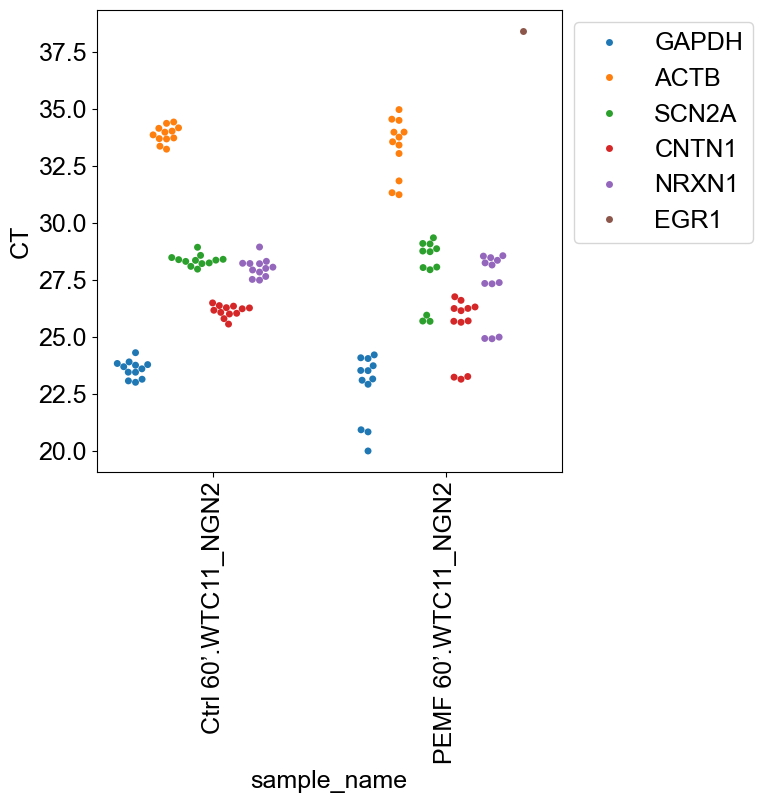

In [17]:
x="sample_name"
y="CT"
data=df#.loc[df["col_pos_x"].astype(int)!= 12]
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1,1))

## ANOVA

### columns

In [18]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(col_pos_x) + C(plate)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.4131
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.956
Time:                        17:16:04   Log-Likelihood:                -338.06
No. Observations:                 123   AIC:                             702.1
Df Residuals:                     110   BIC:                             738.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 29

### primers and samples

In [19]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(primers) + C(sample_name)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     261.6
Date:                Thu, 30 May 2024   Prob (F-statistic):           3.34e-64
Time:                        17:16:04   Log-Likelihood:                -167.22
No. Observations:                 121   AIC:                             348.4
Df Residuals:                     114   BIC:                             368.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### replicate number (proxy for position)

In [20]:
# WTC11-NGN2 PEMF-only CTs
test = df.loc[df["CT"].astype(str)!="None"].copy().dropna()

# test one cell line w/ PEMF exposure only to test if PEMF exposure varies by position. 
test = test.loc[(test['Cell_line'] =="WTC11_NGN2") &
                (test["sample_name"].str.contains("PEMF"))
                ]
# change datatypes
test[["rep"]] = test[["rep"]].astype(str) # make replicates a str (or factor, not an int datatype). 
test["CT"] = test["CT"].astype(float)

# add a constant
test = sm.add_constant(test)

# fit ANOVA model
mod = ols("CT ~ C(rep)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.257
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.298
Time:                        17:16:04   Log-Likelihood:                -168.41
No. Observations:                  61   AIC:                             344.8
Df Residuals:                      57   BIC:                             353.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        28.1926      1.022     27.587

## CT values

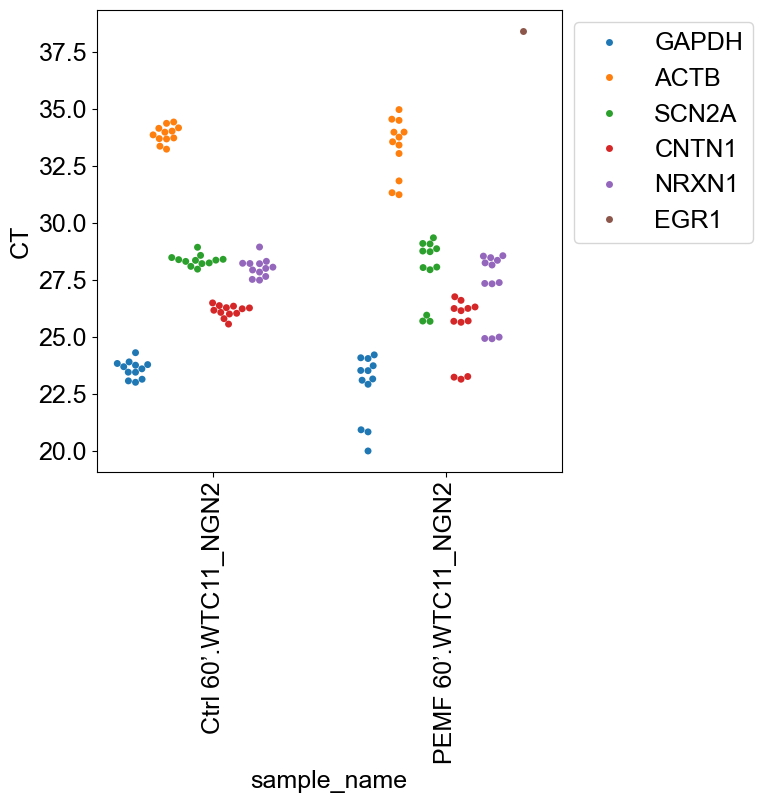

In [21]:
x="sample_name"
y="CT"
data=df#.loc[~df["col_pos_x"].isin([4, 12])]
hue="primers"

fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(RE, f"{DATE}_CT_vals"), bbox_inches="tight")

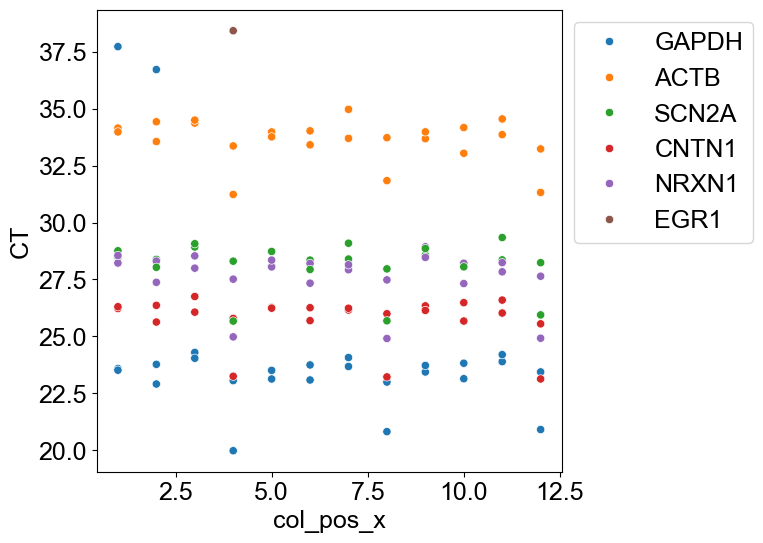

In [22]:
x="col_pos_x"
y="CT"
data=df
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.scatterplot(x=x, y=y, data=data, hue=hue)
ax.legend(bbox_to_anchor=(1,1))

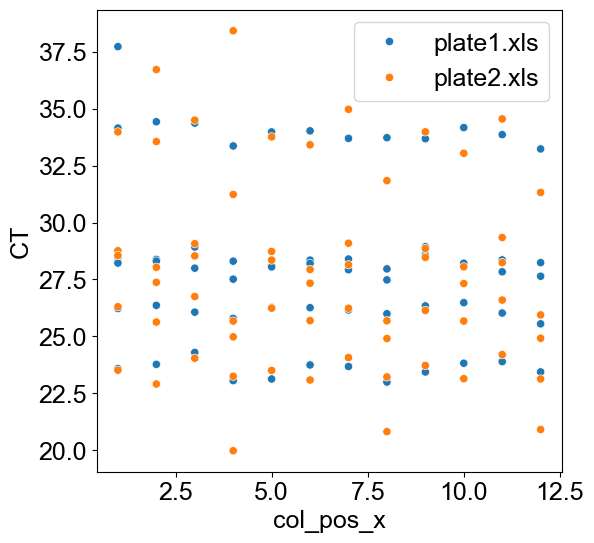

In [23]:
x="col_pos_x"
y="CT"
data=df
hue="plate"
fig, ax=plt.subplots(figsize = (6,6))
sns.scatterplot(x=x, y=y, data=data, hue=hue)
ax.legend(bbox_to_anchor=(1,1))

## compute ddCT with all datapoints

In [24]:
comparisons = [("Ctrl 60’.WTC11_NGN2", "PEMF 60’.WTC11_NGN2"),
               ]
primers = list(df["primers"].unique())
primers.remove("GAPDH")
primers.remove("ACTB")
GENE_LIST = primers
# columns for writing
write_cols = ['Well Position',
              'CT',
              'plate',
              'primers',
              'sample_name',
              'rep',
              'Experiment',
              'Control_mean',
              'dCT',
              'Control_dCT_mean',
              'ddCT',
              'fold_change', 
             "control_gene", 
             "date"]

In [25]:
results = {}

# Analysis

## ACTB

In [27]:
backup = df.copy()
df = backup

In [27]:
control_gene = 'ACTB'

df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_
df_

1.0


,Well Position,CT,plate,col_pos_x,primers,col_pos_y,sample_id,sample_name,rep,Experiment,Cell_line,Control_mean,dCT,Control_dCT_mean,ddCT,fold_change,control_gene
0,A1,23.589615,plate1.xls,1,GAPDH,1,S1,Ctrl 60’.WTC11_NGN2,1.0,1.0,WTC11_NGN2,33.888139,-10.298524,-10.314519,0.015995,0.988975,ACTB
1,A2,23.774992,plate1.xls,2,GAPDH,2,S2,Ctrl 60’.WTC11_NGN2,2.0,1.0,WTC11_NGN2,33.888139,-10.113147,-10.314519,0.201372,0.869723,ACTB
2,A3,24.298092,plate1.xls,3,GAPDH,3,S3,Ctrl 60’.WTC11_NGN2,3.0,1.0,WTC11_NGN2,33.888139,-9.590047,-10.314519,0.724472,0.605219,ACTB
3,A4,23.060104,plate1.xls,4,GAPDH,4,S4,Ctrl 60’.WTC11_NGN2,4.0,1.0,WTC11_NGN2,33.888139,-10.828034,-10.314519,-0.513516,1.427525,ACTB
4,A5,23.132294,plate1.xls,5,GAPDH,5,S1,Ctrl 60’.WTC11_NGN2,1.0,1.0,WTC11_NGN2,33.888139,-10.755845,-10.314519,-0.441326,1.357852,ACTB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,F8,None,plate2.xls,8,EGR1,8,S8,PEMF 60’.WTC11_NGN2,4.0,1.0,WTC11_NGN2,33.344383,NaN,NaN,NaN,NaN,ACTB
140,F9,None,plate2.xls,9,EGR1,9,S5,PEMF 60’.WTC11_NGN2,1.0,1.0,WTC11_NGN2,33.344383,NaN,NaN,NaN,NaN,ACTB
141,F10,None,plate2.xls,10,EGR1,10,S6,PEMF 60’.WTC11_NGN2,2.0,1.0,WTC11_NGN2,33.344383,NaN,NaN,NaN,NaN,ACTB
142,F11,None,plate2.xls,11,EGR1,11,S7,PEMF 60’.WTC11_NGN2,3.0,1.0,WTC11_NGN2,33.344383,NaN,NaN,NaN,NaN,ACTB


exp1 Ctrl 60’.WTC11_NGN2 v. PEMF 60’.WTC11_NGN2 dCT SCN2A 0.767045476436756
sample_name fold_change


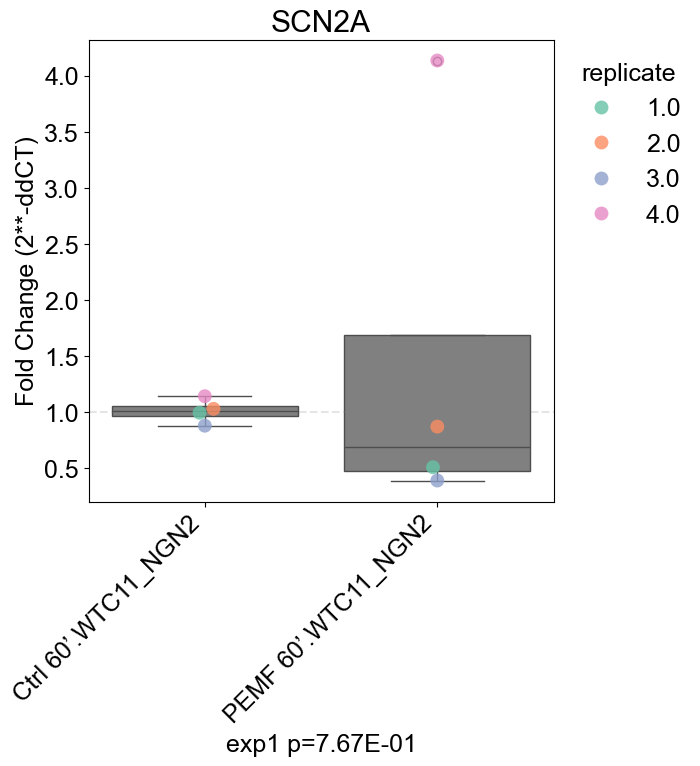

exp1 Ctrl 60’.WTC11_NGN2 v. PEMF 60’.WTC11_NGN2 dCT CNTN1 0.6636741069259178
sample_name fold_change


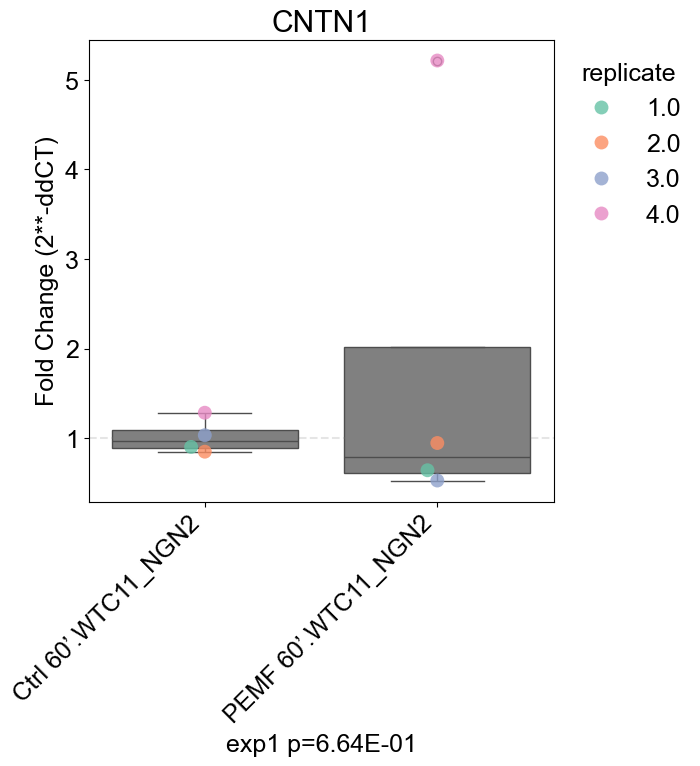

exp1 Ctrl 60’.WTC11_NGN2 v. PEMF 60’.WTC11_NGN2 dCT NRXN1 0.6192916650397382
sample_name fold_change


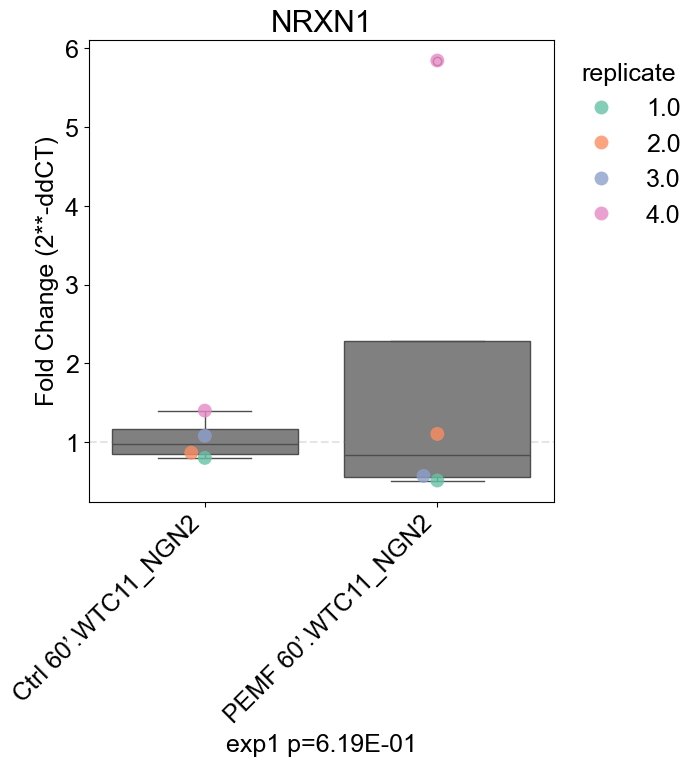

In [28]:
# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in GENE_LIST:
    for ex in  df_["Experiment"].unique():
        if str(ex) !="nan":
            df_ex = df_.loc[df_["Experiment"]==ex]
            plotDct(df_ex, gene, control_gene, DATE)

In [29]:
df_["fold_change"] = df_["fold_change"].astype(float)

df_.groupby(["sample_name", "Experiment", "primers", ])["fold_change"].describe().round(2)["50%"]

sample_name          Experiment  primers
Ctrl 60’.WTC11_NGN2  1.0         ACTB       0.98
                                 CNTN1      0.96
                                 EGR1        NaN
                                 GAPDH      0.96
                                 NRXN1      1.00
                                 SCN2A      1.00
PEMF 60’.WTC11_NGN2  1.0         ACTB       0.81
                                 CNTN1      0.80
                                 EGR1        NaN
                                 GAPDH      0.82
                                 NRXN1      0.86
                                 SCN2A      0.69
Name: 50%, dtype: float64

## GAPDH

In [37]:
control_gene = 'GAPDH'
df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_

1.0


exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT SCN2A 0.4324146927463802
sample_name fold_change


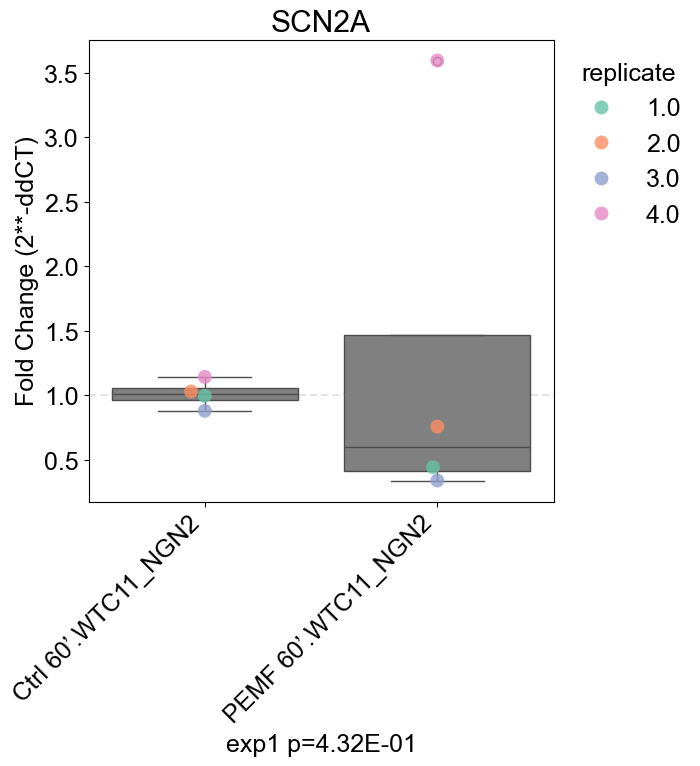

exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT CNTN1 0.952732917521097
sample_name fold_change


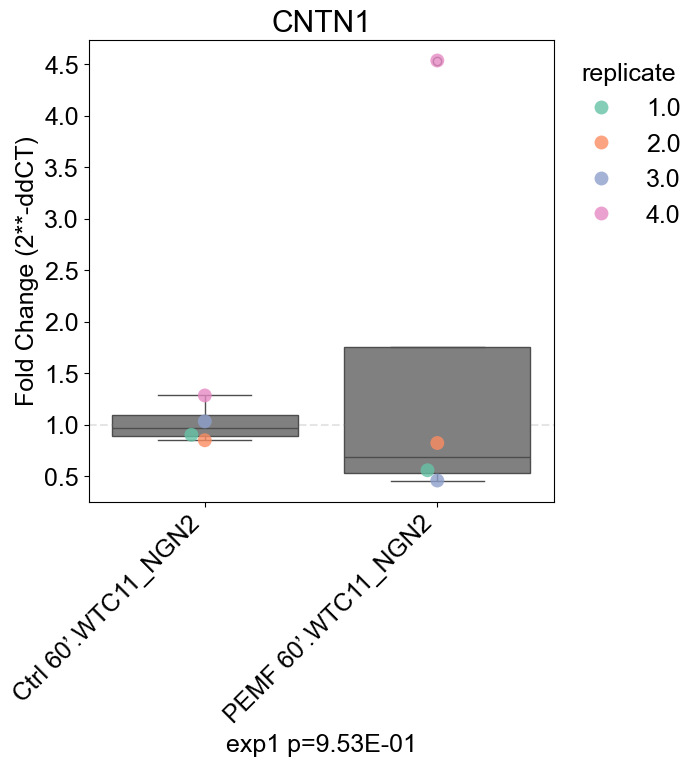

exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT NRXN1 0.9638735173376078
sample_name fold_change


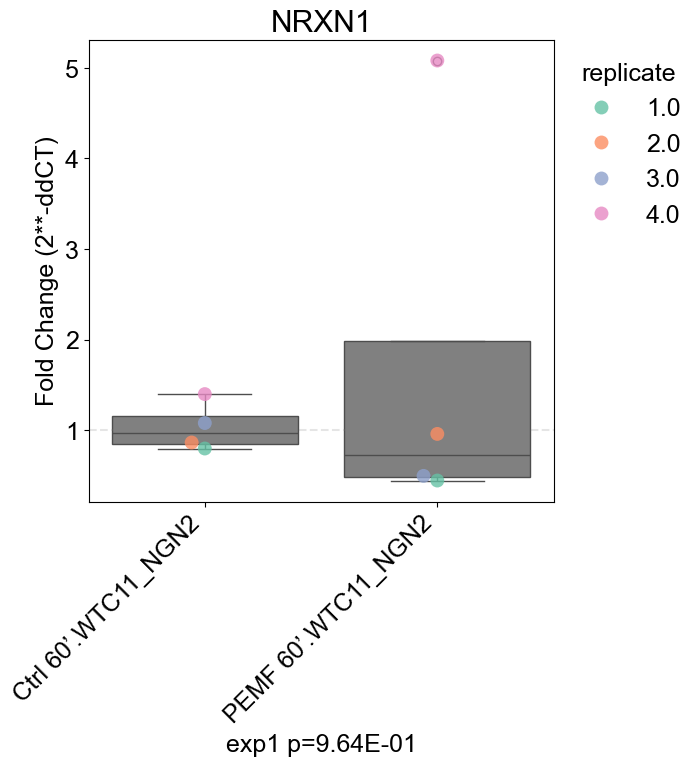

In [38]:
# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in GENE_LIST:
    for ex in  df_["Experiment"].unique():
        if str(ex) !="nan":
            df_ex = df_.loc[df_["Experiment"]==ex].copy()
            plotDct(df_ex, gene, control_gene, DATE)

In [34]:
df_["fold_change"] = df_["fold_change"].astype(float)

df_.groupby(["sample_name", "Experiment", "primers", ])["fold_change"].describe().round(2)["std"]

sample_name          Experiment  primers
Ctrl 60’.WTC11_NGN2  1.0         ACTB       0.27
                                 CNTN1      0.20
                                 EGR1        NaN
                                 GAPDH      0.27
                                 NRXN1      0.27
                                 SCN2A      0.16
PEMF 60’.WTC11_NGN2  1.0         ACTB       1.25
                                 CNTN1      1.78
                                 EGR1        NaN
                                 GAPDH      2.14
                                 NRXN1      2.02
                                 SCN2A      1.41
Name: std, dtype: float64

exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT SCN2A 0.002631557067980465
sample_name fold_change


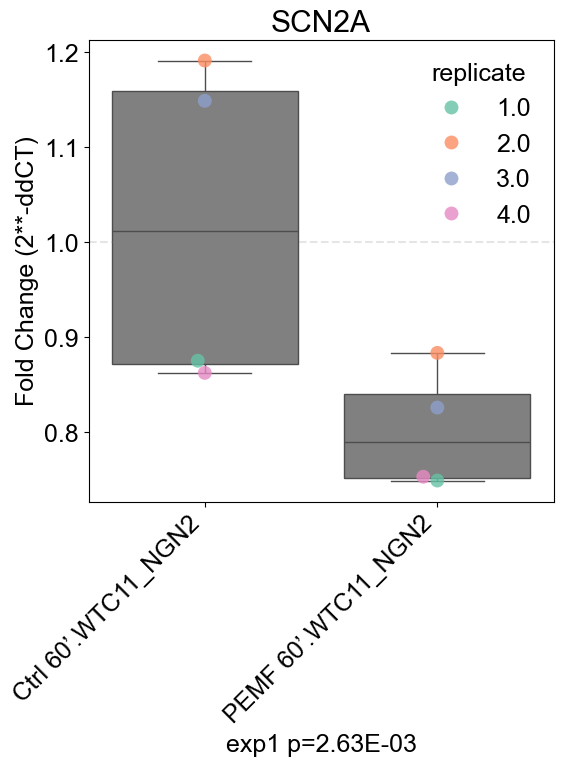

exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT CNTN1 0.8099383937120408
sample_name fold_change


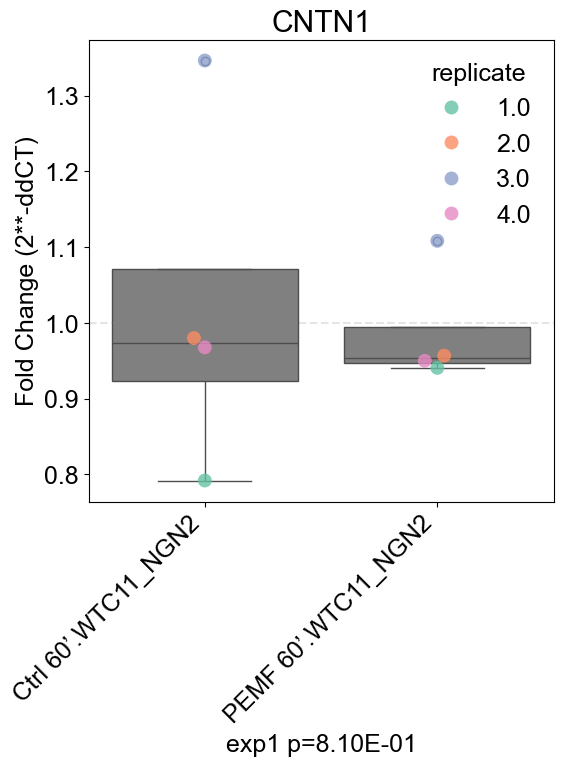

exp1 PEMF 60’.WTC11_NGN2 v. Ctrl 60’.WTC11_NGN2 dCT NRXN1 0.896055015896425
sample_name fold_change


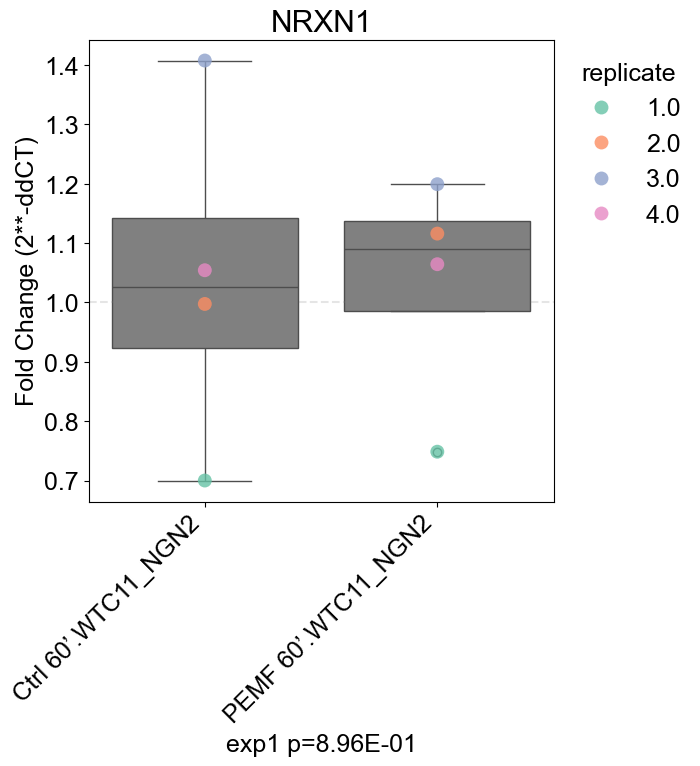

In [36]:
# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in GENE_LIST:
    for ex in  df_["Experiment"].unique():
        if str(ex) !="nan":
            df_ex = df_.loc[df_["Experiment"]==ex].copy()
            plotDct(df_ex, gene, control_gene, DATE)

# write results 

In [35]:
re = pd.concat(results.values())
re["date"] = DATE
re[write_cols].to_csv(RE_DDCT, sep='\t', index=False)

In [36]:
RE

'/Users/sarahfong/Desktop/local_data/EMF/experiments/results'